### All imports

In [4]:
!python3 -m pip install imagehash Image

In [24]:
import imagehash
from PIL import Image
import numpy as np
import torch 
import torchvision
from matplotlib import pyplot as plt

### Hash functions

In [37]:
def phash(image_file: str, hash_size: int = 8) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.phash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

def dhash(image_file: str, hash_size: int = 8) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

def ahash(image_file: str, hash_size: int = 8) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.average_hash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

def whash(image_file: str, hash_size: int = 8) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.whash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [517]:
def convolve(img, weights, hash_size, padding_size = 0):
    tensor_image = torch.reshape(img,(1,1,hash_size, hash_size))
    conv_img = torch.nn.functional.conv2d(tensor_image, weights, padding=int(padding_size))
    conv_img = conv_img.squeeze(0)
    conv_img = torch.permute(conv_img, (1,2,0))
    return conv_img

def gauss_kernel(size, sig=1.):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    res = kernel / np.sum(kernel)
    return torch.DoubleTensor(res.reshape(1,1,size,size))

def sobel_filters(img):
    
    Kx = torch.DoubleTensor([[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]])
    Ky = torch.DoubleTensor([[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]])
    
    img = img.unsqueeze(0)
    img = torch.permute(img, (0,3,1,2))

    Ix = torch.nn.functional.conv2d(img, Kx.unsqueeze(0))
    Iy = torch.nn.functional.conv2d(img, Ky.unsqueeze(0))
    
    return Ix, Iy

def relu(grad, _min):
    return torch.where(grad > _min, grad, 0.)

def shash(image_file: str, hash_size: int, input_size = 32):
    pil_image = Image.open(image_file).resize(
                        (input_size, input_size),
                        Image.BILINEAR).convert("L")

    size = 5
    kernel = gauss_kernel(size)

    np_image = np.array(pil_image).astype(np.float64)
    tensor_image = torch.tensor(np_image)

    image_blurred = convolve(tensor_image, kernel, input_size, int(np.sqrt(size)))
    sobels = sobel_filters(image_blurred)
    
    gradient = np.sqrt(sobels[0]**2 + sobels[1]**2) 

    grad = relu(gradient, 0.5)
    grad = grad.squeeze(0)
    
    pil_image = torchvision.transforms.functional.to_pil_image(grad.to(torch.int32))
    pil_image.resize((hash_size+1, hash_size),Image.BILINEAR)
    dhash = imagehash.dhash(pil_image, 32)
    signature = dhash.hash.flatten()
    pil_image.close()

    return signature, grad.T
    #return grad

In [518]:
def distance(hashA, hashB, hash_size=8):
    hd = sum(np.bitwise_xor(hashA, hashB))
    similarity = (hash_size**2 - hd) / hash_size**2
    return similarity

### Data

In [519]:
imageList = ["1.Data/cat1.jpg", "1.Data/cat2.jpg", "1.Data/cat3.jpg", "1.Data/cat4.jpg"]

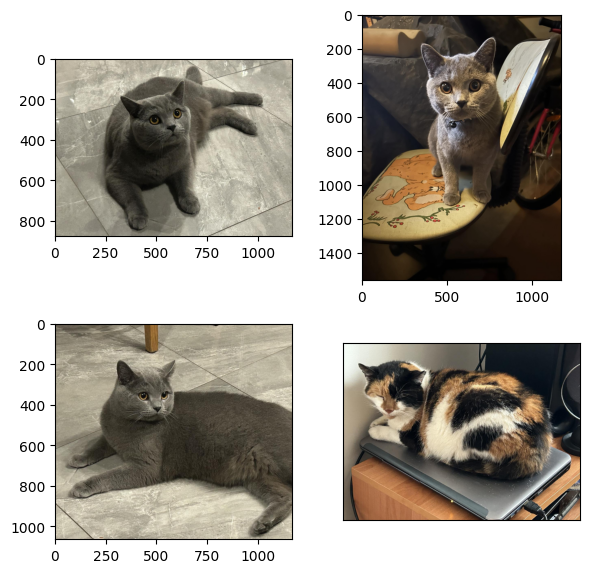

In [520]:
num_row = 2
num_col = 2

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 4):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.open(imageList[0], 'r'))

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(Image.open(imageList[1], 'r'))

    ax = axes[(i+2)//num_col, (i+2)%num_col]
    ax.imshow(Image.open(imageList[2], 'r'))
    
    ax = axes[(i+3)//num_col, (i+3)%num_col]
    ax.imshow(Image.open(imageList[3], 'r'))


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [556]:
hashA = dhash(imageList[0])
hashB = dhash(imageList[3])
distance_ = distance(hashA, hashB)
print(distance_)

0.40625


In [557]:
hashC, gradC = shash(imageList[0], 32)
hashD, gradD = shash(imageList[3], 32)
distance_ = distance(hashC, hashD, 32)
print(distance_)

0.5205078125


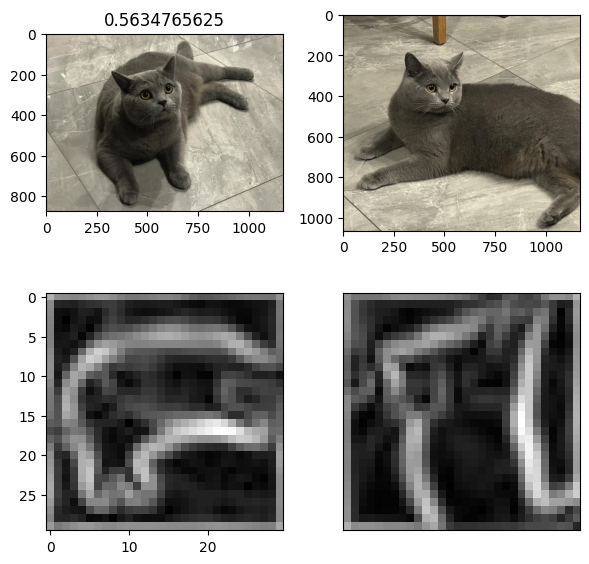

In [549]:
num_row = 2
num_col = 2

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 4):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.open(imageList[0], 'r'))
    ax.set_title(distance_)

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(Image.open(imageList[2], 'r'))

    ax = axes[(i+2)//num_col, (i+2)%num_col]
    ax.imshow(gradC, cmap="gray")
    
    ax = axes[(i+3)//num_col, (i+3)%num_col]
    ax.imshow(gradD, cmap="gray")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

### One image rotated

In [569]:
image1 = Image.open(imageList[0])

In [570]:
image2 = image.rotate(45)

In [571]:
pathA = "1.Data/cat1.jpg"
pathB = "1.Data/cat1Rotate.jpg"
image2.save("1.Data/cat1Rotate.jpg")

In [572]:
hashA = phash(pathA)
hashB = phash(pathB)
distance1 = distance(hashA, hashB)

hashC, gradC = shash(pathA, 32)
hashD, gradD = shash(pathB, 32)
distance2 = distance(hashC, hashD, 32)

print(distance1)
print(distance2)

0.5
0.4404296875


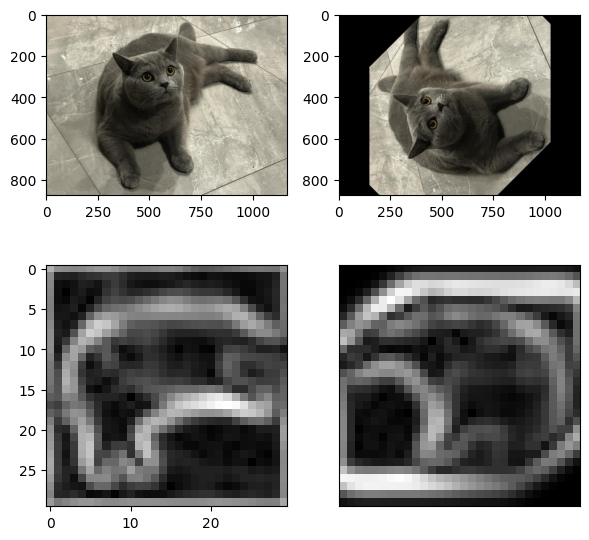

In [573]:
num_row = 2
num_col = 2

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 4):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.open(pathA, 'r'))

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(Image.open(pathB, 'r'))

    ax = axes[(i+2)//num_col, (i+2)%num_col]
    ax.imshow(gradC, cmap="gray")
    
    ax = axes[(i+3)//num_col, (i+3)%num_col]
    ax.imshow(gradD, cmap="gray")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

### Image cropped

In [529]:
image1 = Image.open(imageList[0])

In [530]:
width, height = image1.size
image2 = image1.crop((250, 200, 800, 800))

In [531]:
pathA = "1.Data/cat1.jpg"
pathB = "1.Data/cat1Cropped.jpg"
image2.save(pathB)

In [532]:
hashA = dhash(pathA)
hashB = dhash(pathB)
distance1 = distance(hashA, hashB)

hashC, gradC = shash(pathA, 32)
hashD, gradD = shash(pathB, 32)
distance2 = distance(hashC, hashD, 32)

print(distance1)
print(distance2)

0.5625
0.498046875


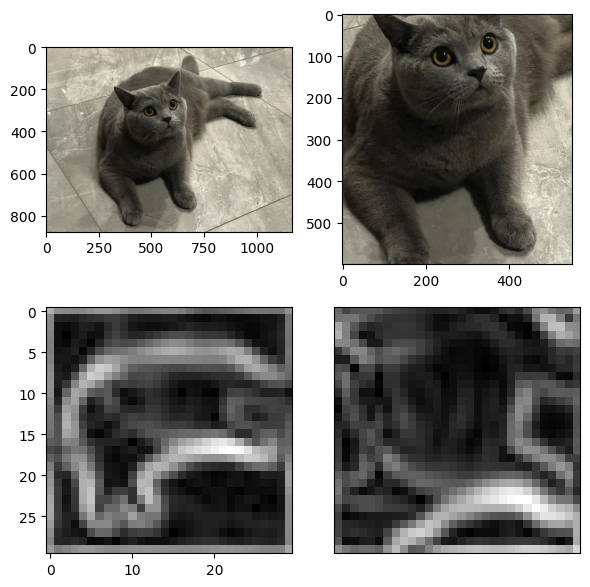

In [533]:
num_row = 2
num_col = 2

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 4):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.open(pathA, 'r'))

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(Image.open(pathB, 'r'))

    ax = axes[(i+2)//num_col, (i+2)%num_col]
    ax.imshow(gradC, cmap="gray")
    
    ax = axes[(i+3)//num_col, (i+3)%num_col]
    ax.imshow(gradD, cmap="gray")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [534]:
#!pip install -U scikit-image

In [535]:
from skimage.metrics import mean_squared_error    
from skimage.metrics import structural_similarity as ssim

In [587]:
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])

	return err
print( mse(gradC.numpy(), gradD.numpy()) )

arrays1 = np.squeeze(gradC.numpy())
arrays2 = np.squeeze(gradD.numpy())
arrays1 *= (255.0/arrays1.max())
arrays2 *= (255.0/arrays2.max())
print(arrays1.min())
print( ssim(arrays1, arrays2, channel_axis=-1, data_range=255))

5116.799019046174
0.0
-0.003203176185636584


In [589]:
from math import log10, sqrt 

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

print(PSNR(arrays1,arrays2))

11.040820020613996


### missing pixels

In [537]:
image1 = Image.open(imageList[0])

In [538]:
pix = numpy.array(image1)

In [539]:
pix.shape

(876, 1170, 3)

In [540]:
for i in range(pix.shape[0]):
    if i % 4 == 0:
        pix[i, :] = 255

for i in range(pix.shape[1]):
    if i % 4 == 0:
        pix[:, i] = 255

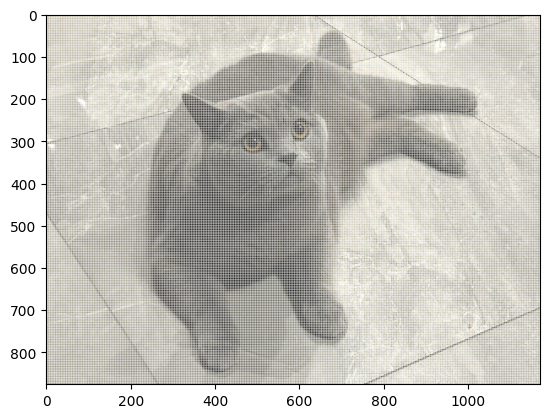

In [541]:
fig = plt.figure()
plt.imshow(pix)

In [542]:
pathA = "1.Data/cat1.jpg"
pathB = "1.Data/cat1Filter1.jpg"
image2.save(pathB)

im = Image.fromarray(np.uint8(pix))
im.save(pathB)

In [543]:
hashA = dhash(pathA)
hashB = dhash(pathB)
distance1 = distance(hashA, hashB)

hashC, gradC = shash(pathA, 32)
hashD, gradD = shash(pathB, 32)
distance2 = distance(hashC, hashD, 32)

print(distance1)
print(distance2)

1.0
0.9462890625


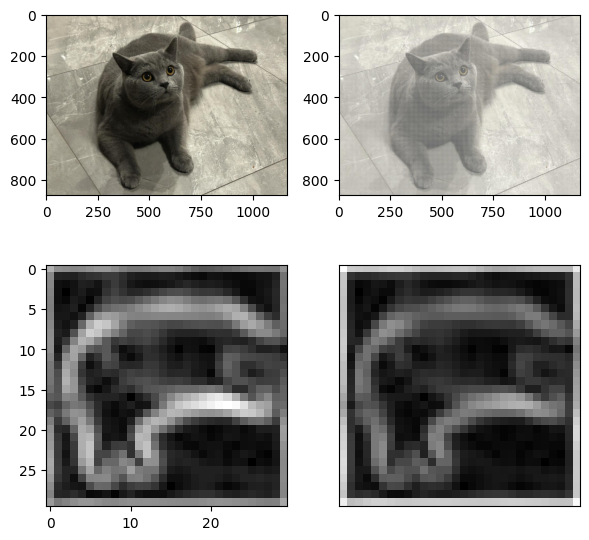

In [544]:
num_row = 2
num_col = 2

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 4):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.open(pathA, 'r'))

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(Image.open(pathB, 'r'))

    ax = axes[(i+2)//num_col, (i+2)%num_col]
    ax.imshow(gradC, cmap="gray")
    
    ax = axes[(i+3)//num_col, (i+3)%num_col]
    ax.imshow(gradD, cmap="gray")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [545]:
hashC

array([False, False, False, ..., False,  True,  True])

In [546]:
hashD

array([False, False, False, ..., False,  True,  True])

### Not correlated picture

In [558]:
image1 = Image.open(imageList[0])

In [580]:
image2 = Image.open("1.Data/dog1.png")

pathA = "1.Data/cat1.jpg"
pathB = "1.Data/dog1.png"

In [581]:
hashA = dhash(pathA)
hashB = dhash(pathB)
distance1 = distance(hashA, hashB)

hashC, gradC = shash(pathA, 32)
hashD, gradD = shash(pathB, 32)
distance2 = distance(hashC, hashD, 32)

print(distance1)
print(distance2)

0.46875
0.5146484375


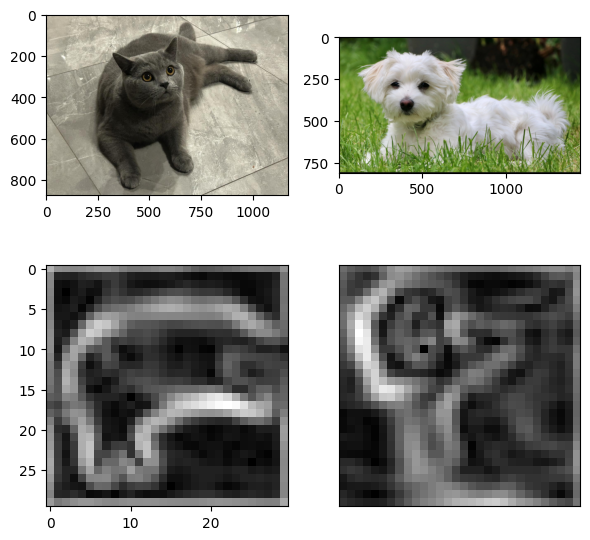

In [582]:
num_row = 2
num_col = 2

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 4):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.open(pathA, 'r'))

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(Image.open(pathB, 'r'))

    ax = axes[(i+2)//num_col, (i+2)%num_col]
    ax.imshow(gradC, cmap="gray")
    
    ax = axes[(i+3)//num_col, (i+3)%num_col]
    ax.imshow(gradD, cmap="gray")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()